# CS156 Assignment 2
**Lending Club Data** | By Korede Akande

**Goal:** Build a model that predicts the largest loan amount that will be successfully funded on the Lending Club platform for any given individual. This model can then be used to advise the applicants on how much they could apply for.

---

## 1. Library Importation

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
from pandas_profiling import ProfileReport
import warnings
warnings.simplefilter(action='ignore')

## 2. Loading the datasets

In [194]:
#Load the full data for accepted and rejected applications
accepted_df = pd.read_csv('accepted.csv', low_memory=False)
rejected_df = pd.read_csv('rejected.csv', low_memory=False)

In [1]:
def sample_generator(filename,pct_of_file= 0.1):
    
    """
    Return a sample of the file, where the sample size is determined by the % specified
    
    Inputs:
        - filename (str): Name of the file to read
        - pct_of_file (float): Percentage of the original file to sample
        
    Output:
        - df (pandas Dataframe): Return the random sample
    
    """
    
    #Load a sample of the dataset
    #If randomly generated probability is greater than pct_of_file, the row will be skipped
    df = pd.read_csv(filename, 
                     skiprows = lambda l: l>0 and np.random.random() > pct_of_file,
                     low_memory=False)
    
    return df

In [ ]:
#Load samples of the datasets for accepted and rejected applications
accepted_df = sample_generator('accepted.csv', 0.5)
rejected_df = sample_generator('rejected.csv', 0.5)

## 3. Previewing the datasets

### a. Accepted Loans Dataframe

In [196]:
#Quick preview of the accepted loans dataset
accepted_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
accepted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


### b. Rejected Loans Dataframe

In [198]:
#Quick preview of the rejected loans dataset
rejected_df.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [199]:
rejected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


## 4. Data Cleaning

Using the [column descriptions](https://resources.lendingclub.com/LCDataDictionary.xlsx) for both datasets as provided in the assigment prompt, variables that appeared to exist in both datasets were manually determined.

**Determination process:**

- Given the rejected dataset has a lot less variables (9 variables), it was used as a starting point. Then for each variable in the rejected stats sheet, the following steps were repeated:
    - Get a relevant keyword from the variable name (e.g. 'policy' in 'Policy Code')
    - Search for this keyword in the LoanStats (Accepted) sheet
    
Doing so, I deduced the following columns (in the RejectStats sheet) to be the only ones consistent in both dataframes: *Amount Requested, Application Date, Loan Title, Debt-To-Income Ratio, Zip Code, State, Employment Length* and *Policy Code*.


**Assumptions:**
- *loan_amnt* in the accepted dataframe is assumed to equal to the amount requested: the individual will not be lent more or less money than they asked for on the platform.
- *issue_d* in the accepted dataframe was assumed to be (roughly) the same as the loan application date in the rejected dataframe. This is based on the following statement from the [Lending Club official website](https://help.lendingclub.com/hc/en-us/articles/214519117-How-long-does-it-take-to-get-a-loan-): "*Most members are approved within 24 hours and receive their money from LendingClub Bank in as little as a few days*". Here there is an implicit assumption that this statement on the website has stayed the same for most of the years.

- **State:**
    - Rejected: State
    - Accepted: addr_state
- **Application Date:**
    - Rejected: Application Date
    - Accepted: issue_d
- **Zip code:**
    - Rejected: Zip Code
    - Accepted: zip_code
- **Employment Length:**
    - Rejected: Employment Length
    - Accepted: emp_length
- **Debt-To-Income Ratio:**
    - Rejected: Debt-To-Income Ratio
    - Accepted: dti
- **Policy Code:**
    - Rejected: Policy Code
    - Accepted: policy_code
- **Loan Title:**
    - Rejected: Loan Title
    - Accepted: title
- **Amount Requested:**
    - Rejected: Amount Requested
    - Accepted: loan_amnt 
    
Where 'Rejected' is the rejected loans dataset and 'Accepted' is the accepted loans dataset

- I drop the Loan Title column as factoring it into the model might require text (pre)processing. This will be considered as a potential extension to the model if accuracy is low.
- Drop Zip Code and State as I don't believe location should affect the acceptance status of a loan. If I do include a location factor, I would probably keep State and drop Zip Code. Since the Zip Code isn't full, I would expect it to be highly duplicated across rows for the same state (this is infact the case)
- Although, I don't feel the Application Date should be a big factor in acceptance vs. rejectance, I do not drop it as it might be interesting to see if the month an individual applies in could influence the acceptance status e.g. due to high loan requests, for example, just before a school semester.


Variables I consider a priority are in line with this [article](https://www.fool.com/the-ascent/personal-loans/articles/5-factors-besides-your-credit-that-affect-personal-loan-approval/)

### a. Getting the relevant subset of the accepted dataset

In [200]:
#Subset the accepted dataframe based on the columns listed in the markdown above
accepted_loans = accepted_df[['loan_amnt','issue_d','dti','emp_length','policy_code']]

accepted_loans.head()

,loan_amnt,issue_d,dti,emp_length,policy_code
0,3600.0,Dec-2015,5.91,10+ years,1.0
1,24700.0,Dec-2015,16.06,10+ years,1.0
2,20000.0,Dec-2015,10.78,10+ years,1.0
3,35000.0,Dec-2015,17.06,10+ years,1.0
4,10400.0,Dec-2015,25.37,3 years,1.0


### b. Renaming columns in the accepted dataset for concatenating

In [201]:
#Rename columns to for easy understanding and concatenating
accepted_loans = accepted_loans.rename(columns={'loan_amnt': 'Amount Requested',
                                                'issue_d': 'Application Date',
                                                'dti': 'Debt-To-Income Ratio',
                                                'emp_length': 'Employment Length',
                                                'policy_code': 'Policy Code'})

accepted_loans.head()

,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Policy Code
0,3600.0,Dec-2015,5.91,10+ years,1.0
1,24700.0,Dec-2015,16.06,10+ years,1.0
2,20000.0,Dec-2015,10.78,10+ years,1.0
3,35000.0,Dec-2015,17.06,10+ years,1.0
4,10400.0,Dec-2015,25.37,3 years,1.0


### c. Dropping columns in the rejected dataset that are unavailable in the accepted dataset

In [202]:
rejected_loans = rejected_df.drop(columns = ['Risk_Score', 'Loan Title', 'Zip Code', 'State'])
rejected_loans.head()

,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Policy Code
0,1000.0,2007-05-26,10%,4 years,0.0
1,1000.0,2007-05-26,10%,< 1 year,0.0
2,11000.0,2007-05-27,10%,1 year,0.0
3,6000.0,2007-05-27,38.64%,< 1 year,0.0
4,1500.0,2007-05-27,9.43%,< 1 year,0.0


### d. Add indicator for loan acceptance to both dataframes
Here 1 indicates an acceptance and 0 represents a rejection

In [203]:
#Indicate in the relevant dataframes if the loan application was accepted or rejected
accepted_loans['Accepted'] = 1
rejected_loans['Accepted'] = 0

### e. Concatenate the dataframes into one big dataframe

In [204]:
#Join the two datasets into one big df and shuffle records around
loan_df = pd.concat([accepted_loans, rejected_loans]).sample(frac=1, random_state=1).reset_index(drop=True)

#Print summary of the dataframe
print(loan_df.info())

loan_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29909442 entries, 0 to 29909441
Data columns (total 6 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Debt-To-Income Ratio  object 
 3   Employment Length     object 
 4   Policy Code           float64
 5   Accepted              int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 1.3+ GB
None


,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Policy Code,Accepted
0,1000.0,2018-02-15,20.3%,< 1 year,0.0,0
1,13000.0,Jul-2018,16.37,6 years,1.0,1
2,20000.0,2015-10-14,11.25%,NaN,0.0,0
3,17000.0,2015-03-21,38.82%,< 1 year,0.0,0
4,3000.0,2013-08-02,7.85%,< 1 year,0.0,0


### f. Data Type Conversion

Looking at the preview of the data and the output of .info(), we see that Application Date and Debt-to-Income (dti) ratio have the wrong data type. They should be datetime and float/percentage, respectively for more accurate manipulation. Additionally, we note that the dates from the accepted and rejected datasets differ in terms of format: the accepted dataset is formatted as M-Y, while the rejected is formatted as Y-M-D. These are all corrected below:

#### > Debt-to-Income Ratio

In [205]:
#Remove percentage symbols from dti values and convert to percentage (float)
loan_df['Debt-To-Income Ratio'] = loan_df['Debt-To-Income Ratio'].astype(str)\
                                                                 .str.replace('%','')\
                                                                 .astype(float)/100

In [206]:
#Get descriptive stats
loan_df['Debt-To-Income Ratio'].describe().round(3)

count    2.990770e+07
mean     1.339000e+00
std      1.013340e+02
min     -1.000000e-02
25%      8.600000e-02
50%      1.970000e-01
75%      3.510000e-01
max      5.000003e+05
Name: Debt-To-Income Ratio, dtype: float64

We note that there are some unreasonable/incorrect dti value (we see the minimum is a negative percentage which is not possible). Thus we explore strange and large dti values. A DTI of 43% is typically the highest ratio a borrower can have and still get qualified for a mortgage, but lenders generally seek ratios of no more than 36% [(Investopedia)](https://www.investopedia.com/terms/d/dti.asp). 

#### > Application Date

In [211]:
#Convert date column to datetime objects, extract the months, and convert to integers (1-Jan to 12-Dec)
loan_df['Application Date'] = pd.to_datetime(loan_df['Application Date']).dt.month.astype('Int64')

In [212]:
loan_df.head()

,Amount Requested,Application Date,Debt-To-Income Ratio,Employment Length,Policy Code,Accepted
0,1000.0,2,0.2030,< 1 year,0.0,0
1,13000.0,7,0.1637,6 years,1.0,1
2,20000.0,10,0.1125,NaN,0.0,0
3,17000.0,3,0.3882,< 1 year,0.0,0
4,3000.0,8,0.0785,< 1 year,0.0,0


### h. Drop rows with NAs

I instead opt to drop the rows with missing NAs (most of which are employment length variables) because these represent a small portion of the data (for both accepted and rejected) as shown below, thus deletion shouldn't influence results very greatly.

In [213]:
#What percentage of rows will we be dropping if we dropped na rows from the accepted dataframe
na_pct_of_accepted = (accepted_loans.shape[0] - accepted_loans.dropna().shape[0])/accepted_loans.shape[0]
print(f"{round(na_pct_of_accepted*100,2)}% of the rows in accepted contain NAs")

6.5% of the rows in accepted contain NAs


In [214]:
#What percentage of rows will we be dropping if we dropped na rows from the rejected dataframe
na_pct_of_rejected = (rejected_loans.shape[0] - rejected_loans.dropna().shape[0])/rejected_loans.shape[0]
print(f"{round(na_pct_of_rejected*100,2)}% of the rows in rejected contain NAs")

3.44% of the rows in rejected contain NAs


In [215]:
print("Number of rows before dropping NAs:", loan_df.shape[0])
cleaned_loan_df = loan_df.dropna(how='any', axis=0)
print("Number of rows after dropping NAs:", cleaned_loan_df.shape[0])
print("Number of rows dropped: ", loan_df.shape[0] - cleaned_loan_df.shape[0])

Number of rows before dropping NAs: 29909442
Number of rows after dropping NAs: 28810215
Number of rows dropped:  1099227


In [216]:
#What percentage of rows were dropped
(549324/14957444)*100

3.6725793524615566

## 5. Data Transformation

Given a Logistic Regression model is intended for use, scaling the data should not change the performance of the model. This is because if there are predictor variables with large ranges that do not effect the dependent variable of interest, the algorithm makes their coefficients small so that they do not greatly influence predictions. Hence, most of my data transformations in this case are encoding:

### Encoding Categorical Variables

To not mislead the model in thinking one category is more important than another, I one-hot encode categorical variables. However, for employment years, I take the opposite approach as from a loan perspective, someone who has a longer employment length might suggest more stability, hence I extract the year (numeric value) from the category and assign as a column value 

In [217]:
#Extract numeric value from the Employment Length
cleaned_loan_df['Employment Length'] = cleaned_loan_df['Employment Length'].replace('< 1 year', '0 years')
cleaned_loan_df['Employment Length'] = cleaned_loan_df['Employment Length'].str.extract(r'([0-9]+)')
cleaned_loan_df['Employment Length'] = pd.to_numeric(cleaned_loan_df['Employment Length'])

In [218]:
#One-hot encode Application month and State
encoded_df = pd.get_dummies(cleaned_loan_df, columns = ['Application Date'])

In [219]:
encoded_df.head()

,Amount Requested,Debt-To-Income Ratio,Employment Length,Policy Code,Accepted,Application Date_1,Application Date_2,Application Date_3,Application Date_4,Application Date_5,Application Date_6,Application Date_7,Application Date_8,Application Date_9,Application Date_10,Application Date_11,Application Date_12
0,1000.0,0.2030,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,13000.0,0.1637,6,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,17000.0,0.3882,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,3000.0,0.0785,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,8500.0,0.2361,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0


## 6. Modeling & Evaluation

I decide to use a logistic regression model because in this scenario we are trying to predict a binary outcome: (accepted or not accepted), which logistic regression is generally know to tackle. It also better models my (realistic) view on the loan acceptance prediction through its use of probabilities: you can't always say for certain based on an individual's factors if they will get a loan or not, you could however assign a probability to reflect some of that uncertainty. A logistic regression model is also a probablistic model, and these have the added benefit that they tend to do well with imbalanced datasets (like ours in this case).

In [231]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, precision_score

### a. Split data into training and test set

In [221]:
#Specify the predictor variables
X = encoded_df.drop(columns=['Accepted'])

#Specify the target variable
y = encoded_df['Accepted']

#Split to training and test set with a 70:30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### b. Fit model on training data on predict on test set
**Note:** Optimal model parameters for the logisitic regression were determined via a grid search cv (see Appendix A)

In [225]:
#Initialize Logistic Regression model with the optimal parameters determined from a grid search cross-validation
#on a smaller dataset which should have roughly the same distribution  (see Appendix)
clf = LogisticRegression(C=1.0, solver= 'lbfgs')

#Fit the model on the train data
clf.fit(X_train, y_train)

#Predict on the test data
y_preds = clf.predict(X_test)

### c. Model Evaluation

It is unclear which of a false rejection or false acceptance is more costly. For a false prediction of acceptance, the individual could end up wasting time compiling documents and applying but not getting the loan and that appears that be the major con: wastage of time. A failed loan application does not affect your credit score unless you apply to many loans in quick succession. 

Meanwhile, a false rejection would mean you forgo the potential loan you could get from the Lending club and have to look elsewhere (which might not have as good rates).

For the purpose of this assignment, I assume a false acceptance is more costly than a false rejection because you waste time applying and waiting for the response from the Lending Club, which might have been substituted applying for another loan instead.

Hence, in this scenario we are interested in the **precision** (the ability of the classifier not to label as positive a sample that is negative) in addition to the general accuracy


In [233]:
test_accuracy = accuracy_score(y_test, y_preds)
print("Precision score: {}".format(precision_score(y_test,y_preds)))
print("Test set accuracy: ", test_accuracy)

Precision score: 0.9623362711204169
Test set accuracy:  0.9969812792105578


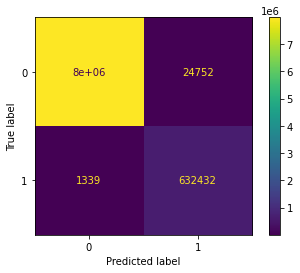

In [227]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()  

In [228]:
print("Coefficients for predictor variables: ")
variables = X.columns
coefficients = clf.coef_

for var, coef in zip(variables, coefficients[0]):
    
    if 'Application Date_' in var:
        
        print('- ', 'Month ' + str(var.replace('Application Date_','')),'=', coef)
    
    else:
        print('- ',var ,'=', coef)

Coefficients for predictor variables: 
-  Amount Requested = -2.3389538928349764e-05
-  Debt-To-Income Ratio = -4.134642041212085
-  Employment Length = 0.20929938612153554
-  Policy Code = 7.690682047875009
-  Month 1 = -0.3425296506195545
-  Month 2 = -0.23171713149534146
-  Month 3 = -0.2387149725593726
-  Month 4 = -0.3287164542309141
-  Month 5 = -0.3890069496679627
-  Month 6 = -0.49423773024412576
-  Month 7 = -0.46953731500870427
-  Month 8 = -0.48002751229679025
-  Month 9 = -0.47591355468563484
-  Month 10 = -0.3179987890600234
-  Month 11 = -0.37192974617726465
-  Month 12 = -0.485366783165484


In [229]:
print(classification_report(y_test, y_preds,target_names=['Rejected','Accepted']))

              precision    recall  f1-score   support

    Rejected       1.00      1.00      1.00   8009294
    Accepted       0.96      1.00      0.98    633771

    accuracy                           1.00   8643065
   macro avg       0.98      1.00      0.99   8643065
weighted avg       1.00      1.00      1.00   8643065



From the classification report above we see that the model does really well on accuracy (1.00) as well as precision (0.96) for the test set, increasing our confidence that it is generalizable to new data

## 7. Predicting Largest Loan Amount that will be funded for any given individual

In [ ]:
def max_loan_amount_predictor(step_size = 100):
    
    #Initialize the max requestable amount to 0, this will be increased interatively to determine the 
    #true max acceptable value
    max_requestable = 0
    
    print("Please enter your information below: ")
    application_month = int(input("What month are you applying in? (Jan-1,Feb-2,..Dec-12) "))   
    debt = float(input("How much are you currently owing in total? "))
    income = float(input("What is your annual income? "))
    employment_length = int(input("How many years have you been at your current job? (Enter 0 if < 1 year) "))
    policy_code = float(input("What's your policy code? (0, 1 or 2) "))
    
    #Assume no loaning to someone without income
    if income <= 0:
        return max_requestable
    
    #Compute the individual's dti
    dti = debt/income
    
    #If the individual has worked more than 10 years, cap at 10 given our model
    if employment_length > 10:
        employment_length = 10
    
    #Note the month the individual is applying in
    application_month_array = np.zeros(12)
    application_month_array[application_month-1] = 1
    
    #New request – next amount to request, we increment by step size
    next_request = max_requestable + step_size
    
    #Create data which will be passed into the model                      
    data = pd.DataFrame([next_request, dti, employment_length, policy_code, *application_month_array]).T
      
    #While the amount requested is accepted and not more than 6 times your annual salary
    while (best_estimator.predict(data)  == 1) and (next_request <= 6*income):
        
        #Update the max requestable amount
        max_requestable = next_request
        
        #Increase the amount
        next_request += step_size
        
        #And check if the loan is still accepted with the increased amount
        data = pd.DataFrame([next_request, dti, employment_length, policy_code, *application_month_array]).T
    
    if max_requestable > 0:
        return (f"The maximum loan amount you could apply for is ${max_requestable - 100} ")
    else:
        return (f"The maximum loan amount you could apply for is ${0}")
    

### Sample Runs

**a. Loan Acceptance**

In [249]:
max_loan_amount_predictor()

Please enter your information below: 
What month are you applying in? (Jan-1,Feb-2,..Dec-12) 5
How much are you currently owing in total? 100
What is your annual income? 2000
How many years have you been at your current job? (Enter 0 if < 1 year) 3
What's your policy code? (0, 1 or 2) 1


'The maximum loan amount you could apply for is $11900 '

**a. Loan Rejection**

In [250]:
max_loan_amount_predictor()

Please enter your information below: 
What month are you applying in? (Jan-1,Feb-2,..Dec-12) 5
How much are you currently owing in total? 10000
What is your annual income? 200
How many years have you been at your current job? (Enter 0 if < 1 year) 4
What's your policy code? (0, 1 or 2) 0


'The maximum loan amount you could apply for is $0'

## Appendix

### a. Cross-validation code on smaller dataset (with results)
#### !!! Be careful re-running! You lose the results shown below

In [ ]:
#Load samples of the datasets for accepted and rejected applications
accepted_df = sample_generator('accepted.csv', 0.01)
rejected_df = sample_generator('rejected.csv', 0.01)

In [111]:
#Specify the predictor variables
X = encoded_df.drop(columns=['Accepted'])

#Specify the target variable
y = encoded_df['Accepted']

#Split to training and test set with a 70:30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Initialize Logistic Regression model
clf = LogisticRegression()

#Create parameter list for optimization trial
#C: Inverse of regularization strength, smaller values specify stronger regularization.
#solver: Try default solver as well as Sag and Saga. The latter are faster for larger datasets (Sklearn)
param_grid = [{'C': [1.0, 0.1, 0.01] ,'max_iter': [500], 'solver': ['lbfgs', 'sag', 'saga']}]

#Run grid search to find best parameters
#I run on a subset because running on a sample of like 2M rows was still running after 2 hrs
grid_search = GridSearchCV(clf, param_grid = param_grid)
grid_search.fit(X_train[:round(len(X_train)/10)], y_train[:round(len(X_train)/10)])

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [1.0, 0.1, 0.01], 'max_iter': [500],
                          'solver': ['lbfgs', 'sag', 'saga']}])

In [112]:
#Get the best params from the grid search
print(f"The best parameters from the grid search were {grid_search.best_params_}")

#Get the best estimator
best_estimator = grid_search.best_estimator_

#Predict class using best parameters
y_gs_pred = best_estimator.predict(X_test)

The best parameters from the grid search were {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}


In [118]:
print(f"There were {len(X_train)} rows of data for the training set")
print(f"There were {len(X_test)} rows of data for the test set")

There were 209600 rows of data for the training set
There were 89829 rows of data for the test set


In [113]:
print("Coefficients for predictor variables: ")
variables = X.columns
coefficients = best_estimator.coef_

for var, coef in zip(variables, coefficients[0]):
    
    if 'Application Date_' in var:
        
        print('- ', 'Month ' + str(var.replace('Application Date_','')),'=', coef)
    
    else:
        print('- ',var ,'=', coef)

Coefficients for predictor variables: 
-  Amount Requested = -7.751546020776982e-06
-  Debt-To-Income Ratio = -0.5928399401149207
-  Employment Length = 0.2172891753086878
-  Policy Code = 7.376147136393904
-  Month 1 = -0.7072266495572977
-  Month 2 = -0.29281914176963736
-  Month 3 = -0.2759858238401665
-  Month 4 = -0.3548141812721871
-  Month 5 = -0.7590970179993761
-  Month 6 = -0.4203981759560921
-  Month 7 = -0.7747375074208613
-  Month 8 = -0.3442879425663216
-  Month 9 = -0.7338211336834859
-  Month 10 = 0.17016120000009421
-  Month 11 = 0.2513773620748405
-  Month 12 = -0.43807488865019395


In [114]:
avg_train_accuracy = grid_search.best_score_
test_accuracy = accuracy_score(y_test, y_gs_pred)
print("Mean validation set accuracy: ", avg_train_accuracy)
print("Test set accuracy: ", test_accuracy)

Mean validation set accuracy:  0.9882633587786259
Test set accuracy:  0.9969052310501063


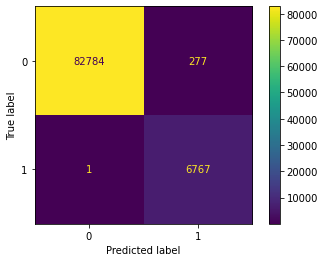

In [115]:
plot_confusion_matrix(best_estimator, X_test, y_test)  
plt.show()  